In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import seaborn as sns

In [454]:
result_dict = {'log': [], 'forest': [], 'boost': []}

In [455]:
item = 'credit_data' # Выбрать из поля Item для вашего датасета
package = 'modeldata' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


## Первая гипотеза. Семейное положение (Marital) влияет на кредитный статус (Status). 

In [456]:
df.Status.unique()

array(['good', 'bad'], dtype=object)

Всего есть два кредитных статуса: "Хороший" и "Плохой"

In [457]:
df.Marital.unique()

array(['married', 'widow', 'single', 'separated', 'divorced', nan],
      dtype=object)

Столбец семейное положение состоит из таких элементов, как: женаты/замужем, вдова/вдовец, холост, живут отдельно, разведены, и nan. NaN означает, наличие пропуска.

In [458]:
df.isnull().sum()

Status         0
Seniority      0
Home           6
Time           0
Age            0
Marital        1
Records        0
Job            2
Expenses       0
Income       381
Assets        47
Debt          18
Amount         0
Price          0
dtype: int64

Для данной гипотезы нужны столбцы Статус и Семейное положение. Семейное положение имеет один пропуск, думаю эту строчку можно спокойно удалить, она не должна повлиять на датасет. 

In [459]:
df = df[df['Marital'].notna()]

In [460]:
df.isnull().sum()

Status         0
Seniority      0
Home           6
Time           0
Age            0
Marital        0
Records        0
Job            2
Expenses       0
Income       381
Assets        47
Debt          18
Amount         0
Price          0
dtype: int64

Для удобства переименую содержимое столбцов Статус и Семейное положение.

In [461]:
df = df.replace({'good': 'Хороший', 'bad': 'Плохой', 'married': 'Женат', 'widow': 'Вдовец', 'single': 'Холост', 
            'separated': 'Живут отдельно', 'divorced': 'Разведены'})

Как видно на графике ниже, в большинстве случаев, заёмщик имеет хорошую репутацию. 

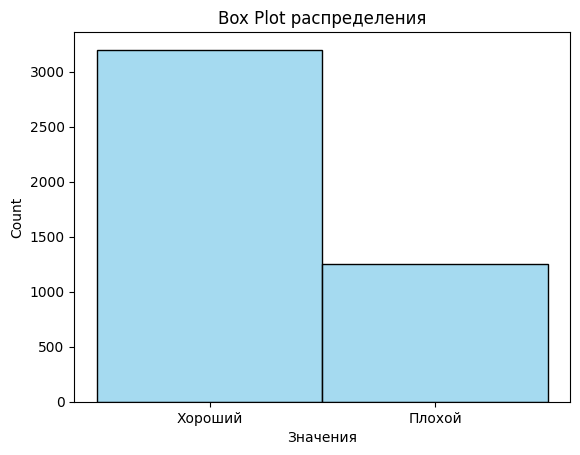

In [463]:
sns.histplot(data=df, x="Status", color="skyblue")
plt.title("Box Plot распределения")
plt.xlabel("Значения")
plt.show()

Теперь необходимо посмотреть на распределение столбца Marital. На графике ниже, видно, что из 4209 заёмщиков, 3000 имеют статус женаты/замужем. Распределение явно не нормальное. 

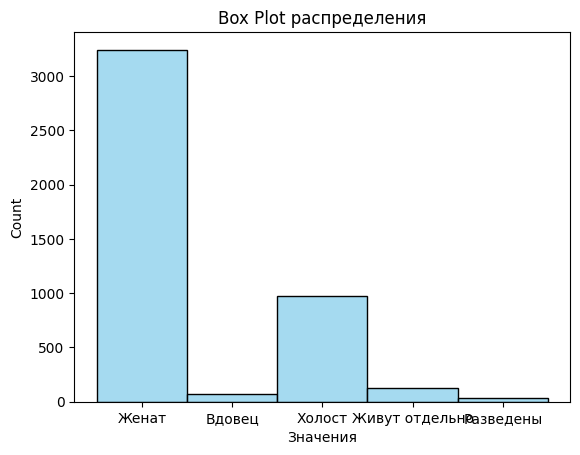

In [464]:
sns.histplot(data=df, x="Marital", color="skyblue")
plt.title("Box Plot распределения")
plt.xlabel("Значения")
plt.show()

Далее была составлена кросс таблица для столбцов Status и Marital

In [465]:
df_task1 = pd.crosstab(df['Status'], df['Marital']) 

In [466]:
df_task1

Marital,Вдовец,Женат,Живут отдельно,Разведены,Холост
Status,,,,,
Плохой,19,829,64,14,328
Хороший,48,2412,66,24,649


In [467]:
from scipy.stats import chi2_contingency

Для проверки гипотезы 2 категориальных переменных можно воспользоваться Тестом Пирсона. 

In [468]:
chi2, p, dof, expected = chi2_contingency(df_task1)

У этого теста нулевая гипотеза говорит, что между кредитным статусом и семейным положением зависимости нет.
p-значение существенно ниже 5%, следовательно, данные противоречат нулевой гипотезе и можно её отвергнуть.
Между кредитным статусом и семейным положение есть зависимость. 

In [469]:
print(f" p-значение: {p}")

 p-значение: 3.6323772983499146e-11


Обоснование гипотезы: Так как переменные имеют значимую зависимость, перед выдачей кредита необходимо смотреть текущий семейный статус. Наиболее стабильные и менее рискованные группы это замужние/женатые и вдовцы

### Задача: Необходимо научить модель предсказывать возможный кредитный статус заемщика. 
#### Данная задача относиться к бинарной классификации. 

##### Категориальная переменная, которую необходимо предсказать. Заемщик может иметь только 2 статуса "хороший" и "плохой"

In [375]:
df.Status.unique()

array(['good', 'bad'], dtype=object)

#### Далее этот столбец необходимо преобразовать из категориального в числовой. 

In [376]:
df['Status_encoded'] = df['Status'].astype('category').cat.codes

In [377]:
df['Status_encoded']

0       1
1       1
2       0
3       1
4       1
       ..
4449    0
4450    1
4451    0
4452    1
4453    1
Name: Status_encoded, Length: 4454, dtype: int8

#### Ниже приведено описание всех категориальных переменных в датасете

In [378]:
df.Home.unique()

array(['rent', 'owner', 'parents', 'priv', 'other', 'ignore', nan],
      dtype=object)

#### Удаление пропусков в столбец Home

In [379]:
df = df[df['Home'].notna()]

In [380]:
df.Home.unique()

array(['rent', 'owner', 'parents', 'priv', 'other', 'ignore'],
      dtype=object)

In [381]:
df.Marital.unique()

array(['married', 'widow', 'single', 'separated', 'divorced', nan],
      dtype=object)

#### Удаление пропусков в столбец Marital


In [382]:
df = df[df['Marital'].notna()]

In [383]:
df.Records.unique()


array(['no', 'yes'], dtype=object)

In [384]:
df.Job.unique()

array(['freelance', 'fixed', 'partime', 'others', nan], dtype=object)

#### Удаление пропусков в столбец Job

In [385]:
df = df[df['Job'].notna()]

In [386]:
df.Job.unique()

array(['freelance', 'fixed', 'partime', 'others'], dtype=object)

#### Далее необходимо изучить числовые переменные 

In [387]:
df.Expenses.isna().sum()

0

In [388]:
df.Income.isna().sum()

377

#### Заполнение пропусков в столбце Income медианой 

In [389]:
median_price = df['Income'].median()
df['income_filled_median'] = df['Income'].fillna(median_price)

In [390]:
df.income_filled_median.isna().sum()

0

#### Заполнение пропусков в столбце Assets медианой 

In [391]:
df.Assets.isna().sum()

41

In [392]:
median_price = df['Assets'].median()
df['assets_filled_median'] = df['Assets'].fillna(median_price)

In [393]:
df['assets_filled_median'].isna().sum()

0

In [394]:
df.Debt.isna().sum()

12

#### Заполнение пропусков в столбце Debt медианой 

In [395]:
median_price = df['Debt'].median()
df['debt_filled_median'] = df['Debt'].fillna(median_price)

In [396]:
df['debt_filled_median'].isna().sum()

0

In [397]:
df.Amount.isna().sum()

0

In [398]:
df.Price.isna().sum()

0

#### Затем необходимо преобразовать категориальные столбцы в числовые, чтобы алгоритм машинного обучения, мог правильно интерпретировать данные 

In [399]:
df_encoded = pd.get_dummies(df, columns=['Home', 'Marital', 'Records', 'Job'])

#### Удаляем не нужные столбцы

In [400]:
df_encoded = df_encoded.drop(['Debt', 'Assets', 'Income', 'Status'], axis=1)

#### Следующий шаг - это разделение датасета, на обучающую, валидационную и тестовую выборку

In [401]:
X = df_encoded.loc[:, df_encoded.columns != 'Status_encoded']
y = df_encoded.Status_encoded

#### 60% выборки идет на обучение, 40% на тест

In [402]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Из тестовой выборки, также надо выделить валидационную 

In [403]:
len_y = len(y_test)
len_x = len(X_test)
y_test_val = y_test[len_y//2:]
y_test = y_test[:(len_y-1)//2]

x_test_val = X_test[len_x//2:]
X_test = X_test[:(len_x-1)//2]



In [404]:
len(y_test), len(y_test_val)

(889, 890)

In [405]:
len(x_test_val), len(X_test)

(890, 889)

In [406]:
len(X_train), len(X_test)

(2667, 889)

In [407]:
len(y_train), len(y_test)

(2667, 889)

#### Первый алгоритм классификации: Логистическая Регрессия

In [408]:
model = LogisticRegression()

In [409]:
model.fit(X_train, y_train)

C:\Users\Maksim\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### 

In [410]:
y_pred = model.predict(X_test)

In [411]:
print("Точность модели на тестовых данных:", accuracy_score(y_test, y_pred))
print("\nОтчет классификации Логистической регрессии:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели на тестовых данных: 0.7367829021372329

Отчет классификации Логистической регрессии:
              precision    recall  f1-score   support

        Good       0.68      0.25      0.37       270
         Bed       0.74      0.95      0.83       619

    accuracy                           0.74       889
   macro avg       0.71      0.60      0.60       889
weighted avg       0.72      0.74      0.69       889



In [412]:
y_pred_val = model.predict(x_test_val)

print("Точность модели на валидационных данных:", accuracy_score(y_test_val, y_pred_val))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели на валидационных данных: 0.751685393258427

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.68      0.25      0.37       270
         Bed       0.74      0.95      0.83       619

    accuracy                           0.74       889
   macro avg       0.71      0.60      0.60       889
weighted avg       0.72      0.74      0.69       889



In [413]:
result_dict['log'].append(accuracy_score(y_test_val, y_pred_val))

#### Второй алгоритм классификации: Случайный лес

In [414]:
from sklearn.ensemble import RandomForestClassifier

# Обучение случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [415]:
# Оцениваем модель
print("Точность модели на тестовых данных:", accuracy_score(y_test, y_pred))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели на тестовых данных: 0.7941507311586051

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.73      0.51      0.60       270
         Bed       0.81      0.92      0.86       619

    accuracy                           0.79       889
   macro avg       0.77      0.71      0.73       889
weighted avg       0.79      0.79      0.78       889



In [416]:
y_pred_val = model.predict(x_test_val)
# Оцениваем модель
print("Точность модели на валидационных данных:", accuracy_score(y_test_val, y_pred_val))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели на валидационных данных: 0.7786516853932585

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.73      0.51      0.60       270
         Bed       0.81      0.92      0.86       619

    accuracy                           0.79       889
   macro avg       0.77      0.71      0.73       889
weighted avg       0.79      0.79      0.78       889



In [417]:
result_dict['forest'].append(accuracy_score(y_test_val, y_pred_val))

#### Третий алгоритм классификации: Градиентный бустинг

In [418]:
from sklearn.ensemble import GradientBoostingClassifier

# Обучение градиентного бустинга
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [419]:
# Оцениваем модель
print("Точность модели на тестовых данных:", accuracy_score(y_test, y_pred))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели на тестовых данных: 0.8087739032620922

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.77      0.53      0.63       270
         Bed       0.82      0.93      0.87       619

    accuracy                           0.81       889
   macro avg       0.80      0.73      0.75       889
weighted avg       0.80      0.81      0.80       889



In [420]:
y_pred_val = model.predict(x_test_val)
# Оцениваем модель
print("Точность модели на валидационных данных:", accuracy_score(y_test_val, y_pred_val))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели на валидационных данных: 0.7943820224719101

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.77      0.53      0.63       270
         Bed       0.82      0.93      0.87       619

    accuracy                           0.81       889
   macro avg       0.80      0.73      0.75       889
weighted avg       0.80      0.81      0.80       889



In [421]:
result_dict['boost'].append(accuracy_score(y_test_val, y_pred_val))

#### Лучший результат показал алгоритм градиентного бустинга с точностью 79%
#### Точность неплохая, однако хотелось бы её увеличить. Для этого можно нормализовать данные.
#### Для этого можно воспользоваться функцией preprocessing

In [422]:
from sklearn import preprocessing

#### Преобразуем все данные, кроме столбца Status_encoded

In [423]:
d = preprocessing.normalize(df_encoded.loc[:, df_encoded.columns != 'Status_encoded'])
scaled_df = pd.DataFrame(d, columns = df_encoded.columns[:len(df_encoded.columns)-1])
scaled_df.head()

,Seniority,Time,Age,Expenses,Amount,Price,Status_encoded,income_filled_median,assets_filled_median,debt_filled_median,...,Marital_divorced,Marital_married,Marital_separated,Marital_single,Marital_widow,Records_no,Records_yes,Job_fixed,Job_freelance,Job_others
0,0.007655,0.051033,0.025517,0.062091,0.680446,0.719571,0.109722,0.000000,0.0,0.0,...,0.000851,0.0,0.000000,0.000000,0.000851,0.000000,0.000000,0.000851,0.0,0.0
1,0.008749,0.030878,0.029849,0.024703,0.514638,0.853270,0.067418,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000515,0.000515,0.000000,0.000515,0.000000,0.0,0.0
2,0.002134,0.007682,0.009816,0.019205,0.426772,0.636957,0.042677,0.640158,0.0,0.0,...,0.000213,0.0,0.000000,0.000000,0.000000,0.000213,0.000000,0.000213,0.0,0.0
3,0.000000,0.020161,0.008064,0.021169,0.302414,0.445220,0.061155,0.840038,0.0,0.0,...,0.000000,0.0,0.000336,0.000000,0.000336,0.000000,0.000336,0.000000,0.0,0.0
4,0.000000,0.037136,0.026821,0.047452,0.319785,0.938723,0.110377,0.000000,0.0,0.0,...,0.000000,0.0,0.001032,0.000000,0.001032,0.000000,0.001032,0.000000,0.0,0.0


In [424]:
scaled_df['Status_encoded'] = df_encoded['Status_encoded']

In [425]:
scaled_df = scaled_df.dropna()

In [426]:
X = scaled_df.loc[:, scaled_df.columns != 'Status_encoded']
y = scaled_df.Status_encoded

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [428]:
len_y = len(y_test)
len_x = len(X_test)
y_test_val = y_test[len_y//2:]
y_test = y_test[:(len_y-1)//2]

x_test_val = X_test[len_x//2:]
X_test = X_test[:(len_x-1)//2]

#### Первый алгоритм классификации: Логистическая Регрессия

In [429]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Оцениваем модель
print("Точность модели:", accuracy_score(y_test, y_pred))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели: 0.7001127395715896

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00       266
         Bed       0.70      1.00      0.82       621

    accuracy                           0.70       887
   macro avg       0.35      0.50      0.41       887
weighted avg       0.49      0.70      0.58       887



C:\Users\Maksim\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Maksim\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Maksim\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [430]:
y_pred_val = model.predict(x_test_val)
# Оцениваем модель
print("Точность модели:", accuracy_score(y_test_val, y_pred_val))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели: 0.7195945945945946

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00       266
         Bed       0.70      1.00      0.82       621

    accuracy                           0.70       887
   macro avg       0.35      0.50      0.41       887
weighted avg       0.49      0.70      0.58       887



C:\Users\Maksim\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Maksim\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Maksim\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [431]:
result_dict['log'].append(accuracy_score(y_test_val, y_pred_val))

#### Второй алгоритм классификации: Случайный лес

In [432]:
# Обучение случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [433]:
# Оцениваем модель
print("Точность модели:", accuracy_score(y_test, y_pred))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели: 0.6719278466741826

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.27      0.06      0.09       266
         Bed       0.70      0.94      0.80       621

    accuracy                           0.67       887
   macro avg       0.49      0.50      0.45       887
weighted avg       0.57      0.67      0.59       887



In [434]:
y_pred_val = model.predict(x_test_val)
# Оцениваем модель
print("Точность модели:", accuracy_score(y_test_val, y_pred_val))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели: 0.7015765765765766

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.27      0.06      0.09       266
         Bed       0.70      0.94      0.80       621

    accuracy                           0.67       887
   macro avg       0.49      0.50      0.45       887
weighted avg       0.57      0.67      0.59       887



In [435]:
result_dict['forest'].append(accuracy_score(y_test_val, y_pred_val))

#### Третий алгоритм классификации: Градиентный бустинг

In [436]:
# Обучение градиентного бустинга
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Оценка точности
accuracy = model.score(X_test, y_test)
print("Точность модели:", accuracy)

Точность модели: 0.677564825253664


In [437]:
# Оцениваем модель
print("Точность модели:", accuracy_score(y_test, y_pred))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели: 0.677564825253664

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.12      0.01      0.02       266
         Bed       0.69      0.96      0.81       621

    accuracy                           0.68       887
   macro avg       0.40      0.49      0.41       887
weighted avg       0.52      0.68      0.57       887



In [438]:
y_pred_val = model.predict(x_test_val)
# Оцениваем модель
print("Точность модели:", accuracy_score(y_test_val, y_pred_val))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bed']))

Точность модели: 0.7072072072072072

Отчет классификации:
              precision    recall  f1-score   support

        Good       0.12      0.01      0.02       266
         Bed       0.69      0.96      0.81       621

    accuracy                           0.68       887
   macro avg       0.40      0.49      0.41       887
weighted avg       0.52      0.68      0.57       887



In [439]:
result_dict['boost'].append(accuracy_score(y_test_val, y_pred_val))

In [444]:
d = pd.DataFrame(data = result_dict, index = ['Не нормализованные', 'Нормализованные'])

#### В таблице ниже видно, что модели обученные на нормализованных данных, имеют результат ниже. 
#### Так лучше всего српавился алгоритм градиентного бустинга, обученный на не нормализованных данных. 
#### Итоговый результат: 79%

In [445]:
d

,log,forest,boost
Не нормализованные,0.751685,0.778652,0.794382
Нормализованные,0.719595,0.701577,0.707207


#### Практическая  значимость: Если у кредитора есть сомнения по поводу заемщика, то он может при помощи данной модели, дополнительно оценить статус заемщики. И затем сделать вывод по поводу кредита